In [18]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import os

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [19]:
# Define paths to the first file in each directory
audio_files = {
    'Voice 1': r'Voice samples 1\Voice 1 - Early 1.wav',
    'Voice 2': r'voice sample 2\early 1.wav',
    'Voice 3': r'voice sample 3\early 1.wav'
}

# Store analysis results
analysis_results = {}

In [20]:
def analyze_audio_file(file_path, label):
    """
    Comprehensive audio analysis to determine frequency ranges
    """
    print(f"\n{'='*60}")
    print(f"Analyzing: {label}")
    print(f"File: {file_path}")
    print(f"{'='*60}\n")
    
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    duration = len(y) / sr
    
    print(f"Sample Rate: {sr} Hz")
    print(f"Duration: {duration:.2f} seconds")
    print(f"Total Samples: {len(y)}")
    
    # 1. Pitch Analysis
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = []
    
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]
        if pitch > 0:  # Only consider non-zero pitches
            pitch_values.append(pitch)
    
    if pitch_values:
        min_pitch = np.min(pitch_values)
        max_pitch = np.max(pitch_values)
        mean_pitch = np.mean(pitch_values)
        median_pitch = np.median(pitch_values)
        
        print(f"\nPitch Analysis:")
        print(f"  Minimum Pitch: {min_pitch:.2f} Hz")
        print(f"  Maximum Pitch: {max_pitch:.2f} Hz")
        print(f"  Mean Pitch: {mean_pitch:.2f} Hz")
        print(f"  Median Pitch: {median_pitch:.2f} Hz")
    
    # 2. Spectral Analysis
    # Compute FFT
    fft_vals = np.abs(fft(y))
    fft_freq = fftfreq(len(y), 1/sr)
    
    # Only positive frequencies
    pos_mask = fft_freq > 0
    fft_freq_pos = fft_freq[pos_mask]
    fft_vals_pos = fft_vals[pos_mask]
    
    # Find significant frequency content (above threshold)
    threshold = np.max(fft_vals_pos) * 0.01  # 1% of max
    significant_freqs = fft_freq_pos[fft_vals_pos > threshold]
    
    if len(significant_freqs) > 0:
        spectral_min = np.min(significant_freqs)
        spectral_max = np.max(significant_freqs)
        
        print(f"\nSpectral Analysis (FFT):")
        print(f"  Minimum Significant Frequency: {spectral_min:.2f} Hz")
        print(f"  Maximum Significant Frequency: {spectral_max:.2f} Hz")
    
    # 3. Formant Analysis using LPC
    # Pre-emphasis filter
    pre_emphasis = 0.97
    y_emphasized = np.append(y[0], y[1:] - pre_emphasis * y[:-1])
    
    # Frame the signal
    frame_length = int(0.025 * sr)  # 25ms frames
    hop_length = int(0.010 * sr)    # 10ms hop
    
    frames = librosa.util.frame(y_emphasized, frame_length=frame_length, hop_length=hop_length)
    
    # Extract formants from voiced frames
    formants_f1 = []
    formants_f2 = []
    formants_f3 = []
    
    for frame in frames.T:
        if np.sum(frame**2) > 0.01:  # Only process frames with energy
            # LPC analysis
            lpc_order = int(sr / 1000) + 2  # Rule of thumb
            try:
                a = librosa.lpc(frame, order=lpc_order)
                # Find roots and convert to frequencies
                roots = np.roots(a)
                roots = roots[np.imag(roots) >= 0]
                
                # Convert to Hz
                angz = np.arctan2(np.imag(roots), np.real(roots))
                freqs = angz * (sr / (2 * np.pi))
                
                # Filter formants (typically 200-4000 Hz range)
                formant_freqs = sorted([f for f in freqs if 200 < f < 4000])
                
                if len(formant_freqs) >= 1:
                    formants_f1.append(formant_freqs[0])
                if len(formant_freqs) >= 2:
                    formants_f2.append(formant_freqs[1])
                if len(formant_freqs) >= 3:
                    formants_f3.append(formant_freqs[2])
            except:
                pass
    
    if formants_f1:
        print(f"\nFormant Analysis:")
        print(f"  F1 Range: {np.min(formants_f1):.2f} - {np.max(formants_f1):.2f} Hz (Mean: {np.mean(formants_f1):.2f} Hz)")
    if formants_f2:
        print(f"  F2 Range: {np.min(formants_f2):.2f} - {np.max(formants_f2):.2f} Hz (Mean: {np.mean(formants_f2):.2f} Hz)")
    if formants_f3:
        print(f"  F3 Range: {np.min(formants_f3):.2f} - {np.max(formants_f3):.2f} Hz (Mean: {np.mean(formants_f3):.2f} Hz)")
    
    # 4. Energy distribution analysis
    # Compute STFT
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    # Find frequency bins with significant energy
    freq_bins = librosa.fft_frequencies(sr=sr)
    energy_per_freq = np.mean(S_db, axis=1)
    
    # Find 95% energy bandwidth
    energy_cumsum = np.cumsum(10**(energy_per_freq/10))
    energy_cumsum = energy_cumsum / energy_cumsum[-1]
    
    f_low_idx = np.where(energy_cumsum >= 0.025)[0][0]
    f_high_idx = np.where(energy_cumsum >= 0.975)[0][0]
    
    f_low_95 = freq_bins[f_low_idx]
    f_high_95 = freq_bins[f_high_idx]
    
    print(f"\nEnergy Distribution (95% bandwidth):")
    print(f"  Lower bound (2.5%): {f_low_95:.2f} Hz")
    print(f"  Upper bound (97.5%): {f_high_95:.2f} Hz")
    
    # Store results
    results = {
        'sr': sr,
        'duration': duration,
        'pitch_min': min_pitch if pitch_values else None,
        'pitch_max': max_pitch if pitch_values else None,
        'pitch_mean': mean_pitch if pitch_values else None,
        'spectral_min': spectral_min if len(significant_freqs) > 0 else None,
        'spectral_max': spectral_max if len(significant_freqs) > 0 else None,
        'f1_range': (np.min(formants_f1), np.max(formants_f1)) if formants_f1 else None,
        'f2_range': (np.min(formants_f2), np.max(formants_f2)) if formants_f2 else None,
        'f3_range': (np.min(formants_f3), np.max(formants_f3)) if formants_f3 else None,
        'energy_95_low': f_low_95,
        'energy_95_high': f_high_95,
        'y': y,
        'sr': sr
    }
    
    return results

In [21]:
# Analyze all three voice samples
for voice_name, file_path in audio_files.items():
    results = analyze_audio_file(file_path, voice_name)
    analysis_results[voice_name] = results


Analyzing: Voice 1
File: Voice samples 1\Voice 1 - Early 1.wav

Sample Rate: 44100 Hz
Duration: 24.01 seconds
Total Samples: 1058891

Pitch Analysis:
  Minimum Pitch: 140.11 Hz
  Maximum Pitch: 2806.87 Hz
  Mean Pitch: 606.09 Hz
  Median Pitch: 432.28 Hz

Spectral Analysis (FFT):
  Minimum Significant Frequency: 0.79 Hz
  Maximum Significant Frequency: 10579.80 Hz

Formant Analysis:
  F1 Range: 527.47 - 1052.47 Hz (Mean: 644.89 Hz)
  F2 Range: 1264.02 - 1736.66 Hz (Mean: 1577.27 Hz)
  F3 Range: 2291.89 - 2555.17 Hz (Mean: 2409.21 Hz)

Energy Distribution (95% bandwidth):
  Lower bound (2.5%): 43.07 Hz
  Upper bound (97.5%): 3962.11 Hz

Analyzing: Voice 2
File: voice sample 2\early 1.wav

Sample Rate: 24000 Hz
Duration: 9.73 seconds
Total Samples: 233431

Pitch Analysis:
  Minimum Pitch: 149.56 Hz
  Maximum Pitch: 1172.18 Hz
  Mean Pitch: 409.15 Hz
  Median Pitch: 334.47 Hz

Spectral Analysis (FFT):
  Minimum Significant Frequency: 49.04 Hz
  Maximum Significant Frequency: 11120.68 Hz


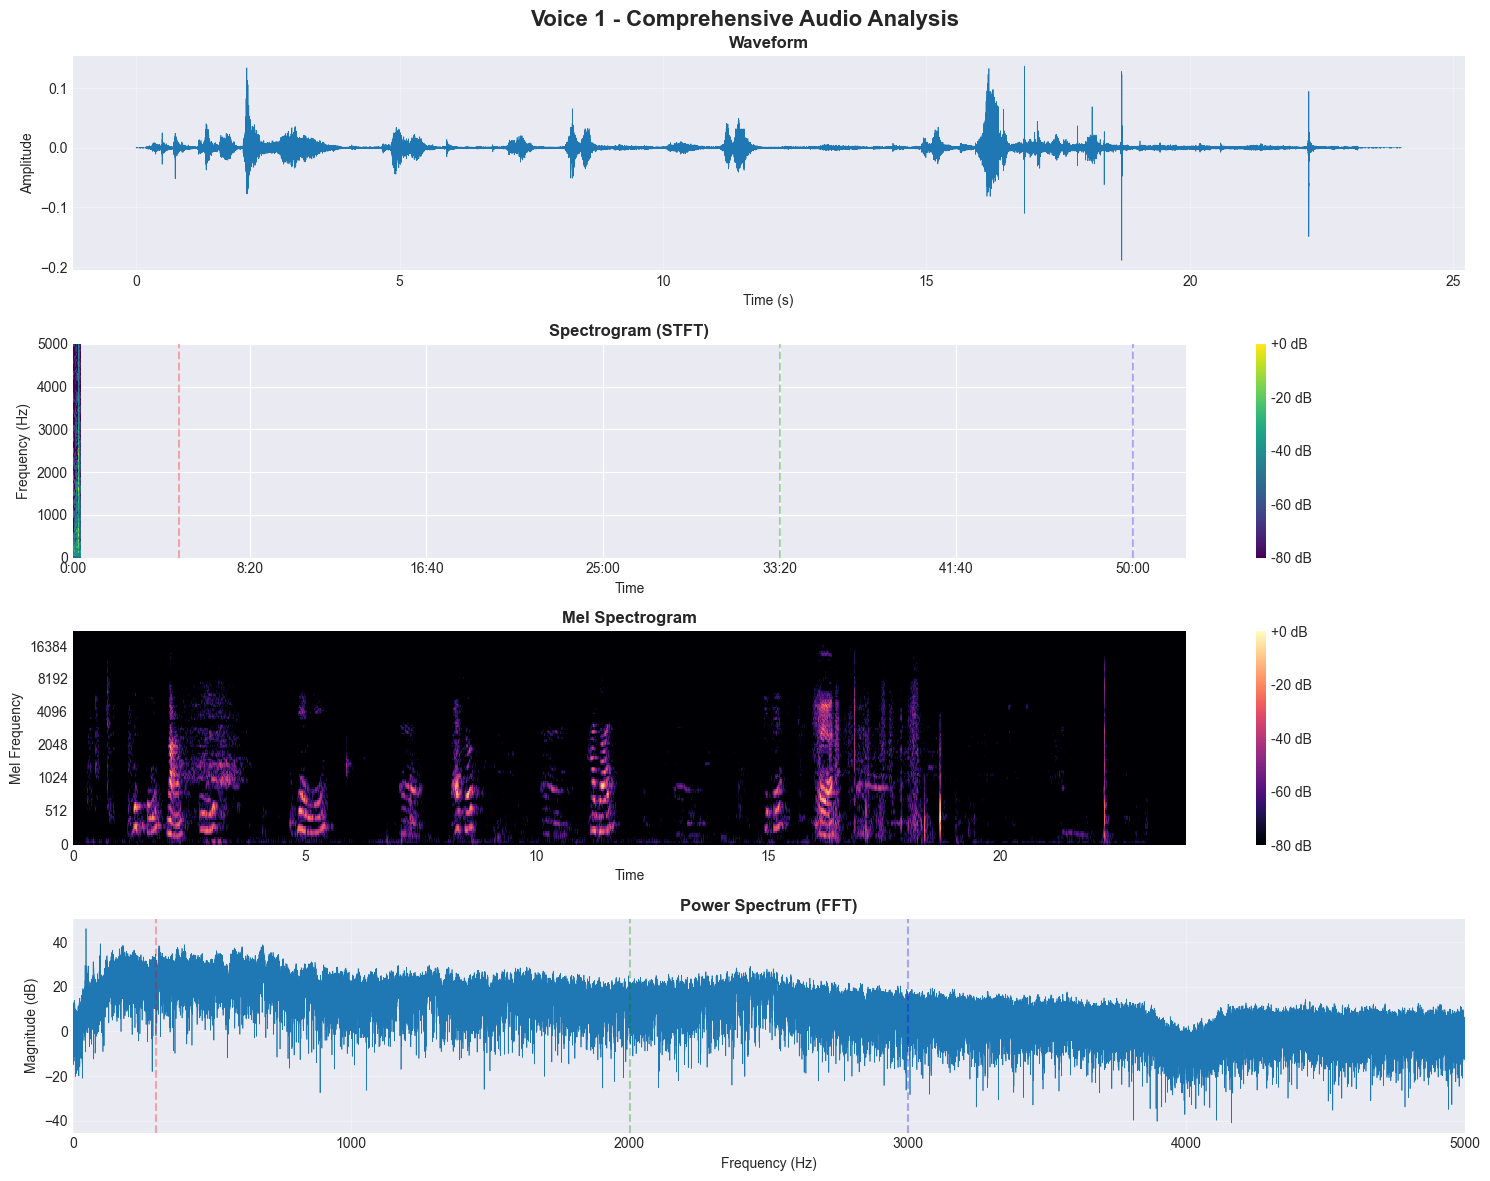

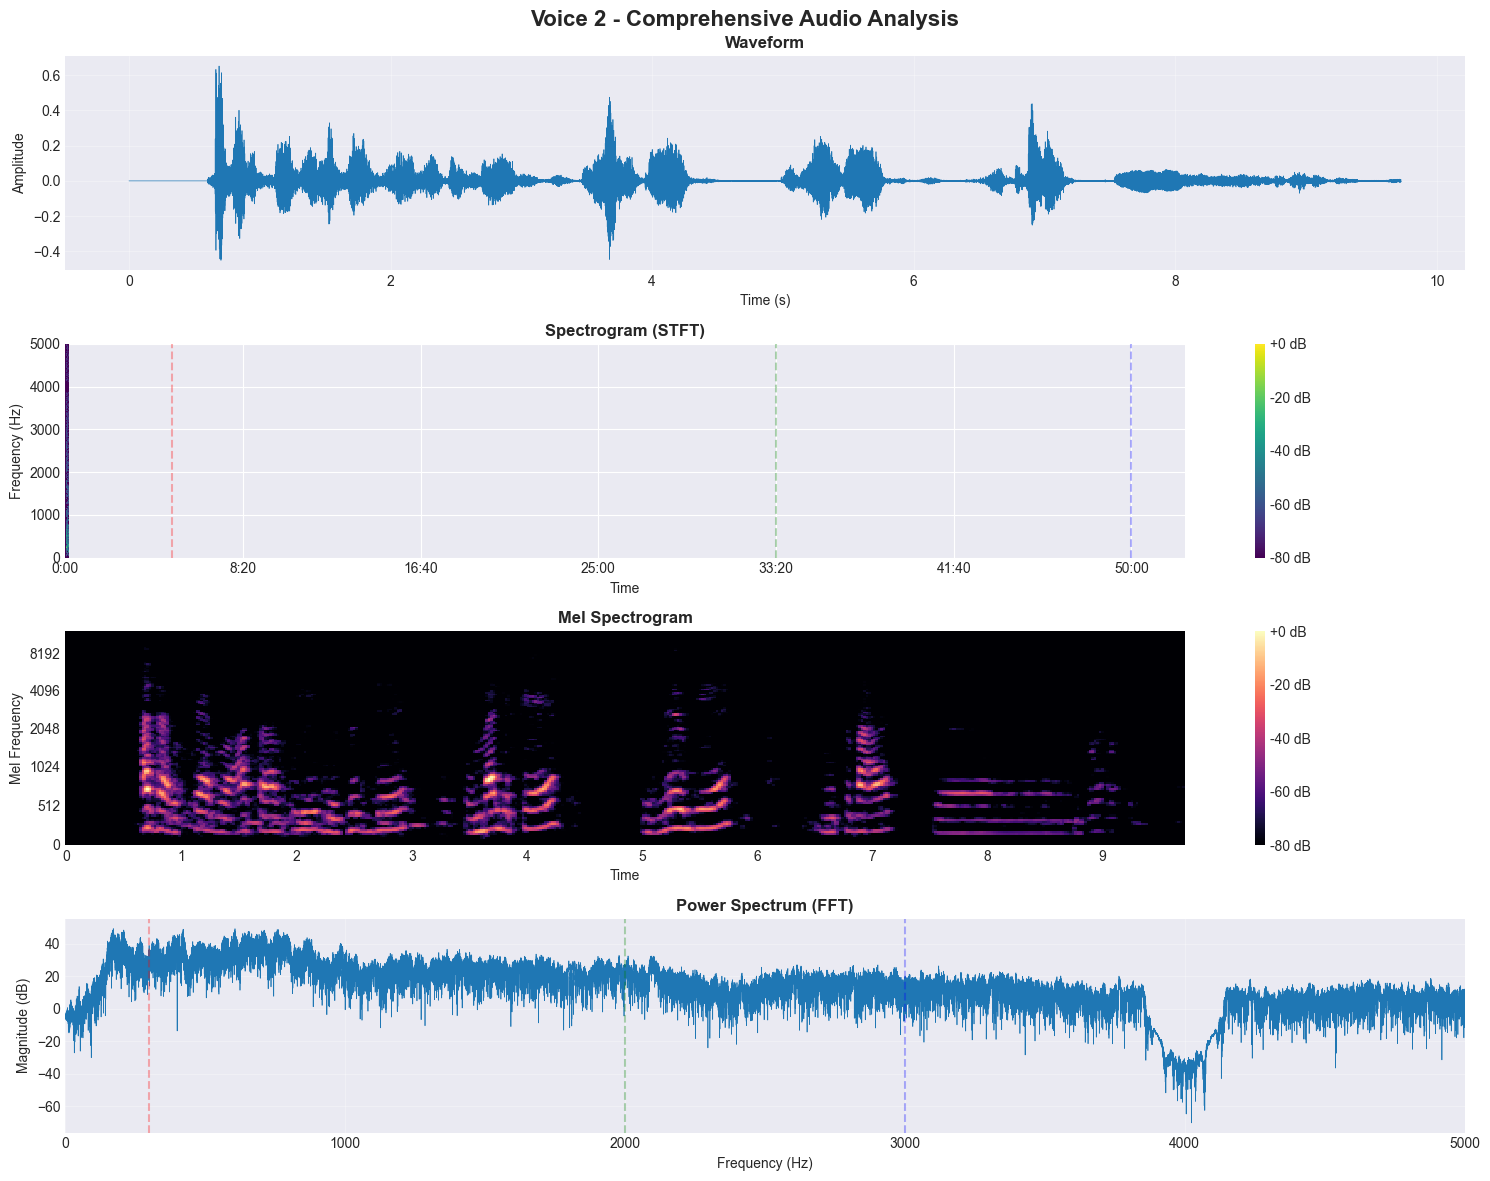

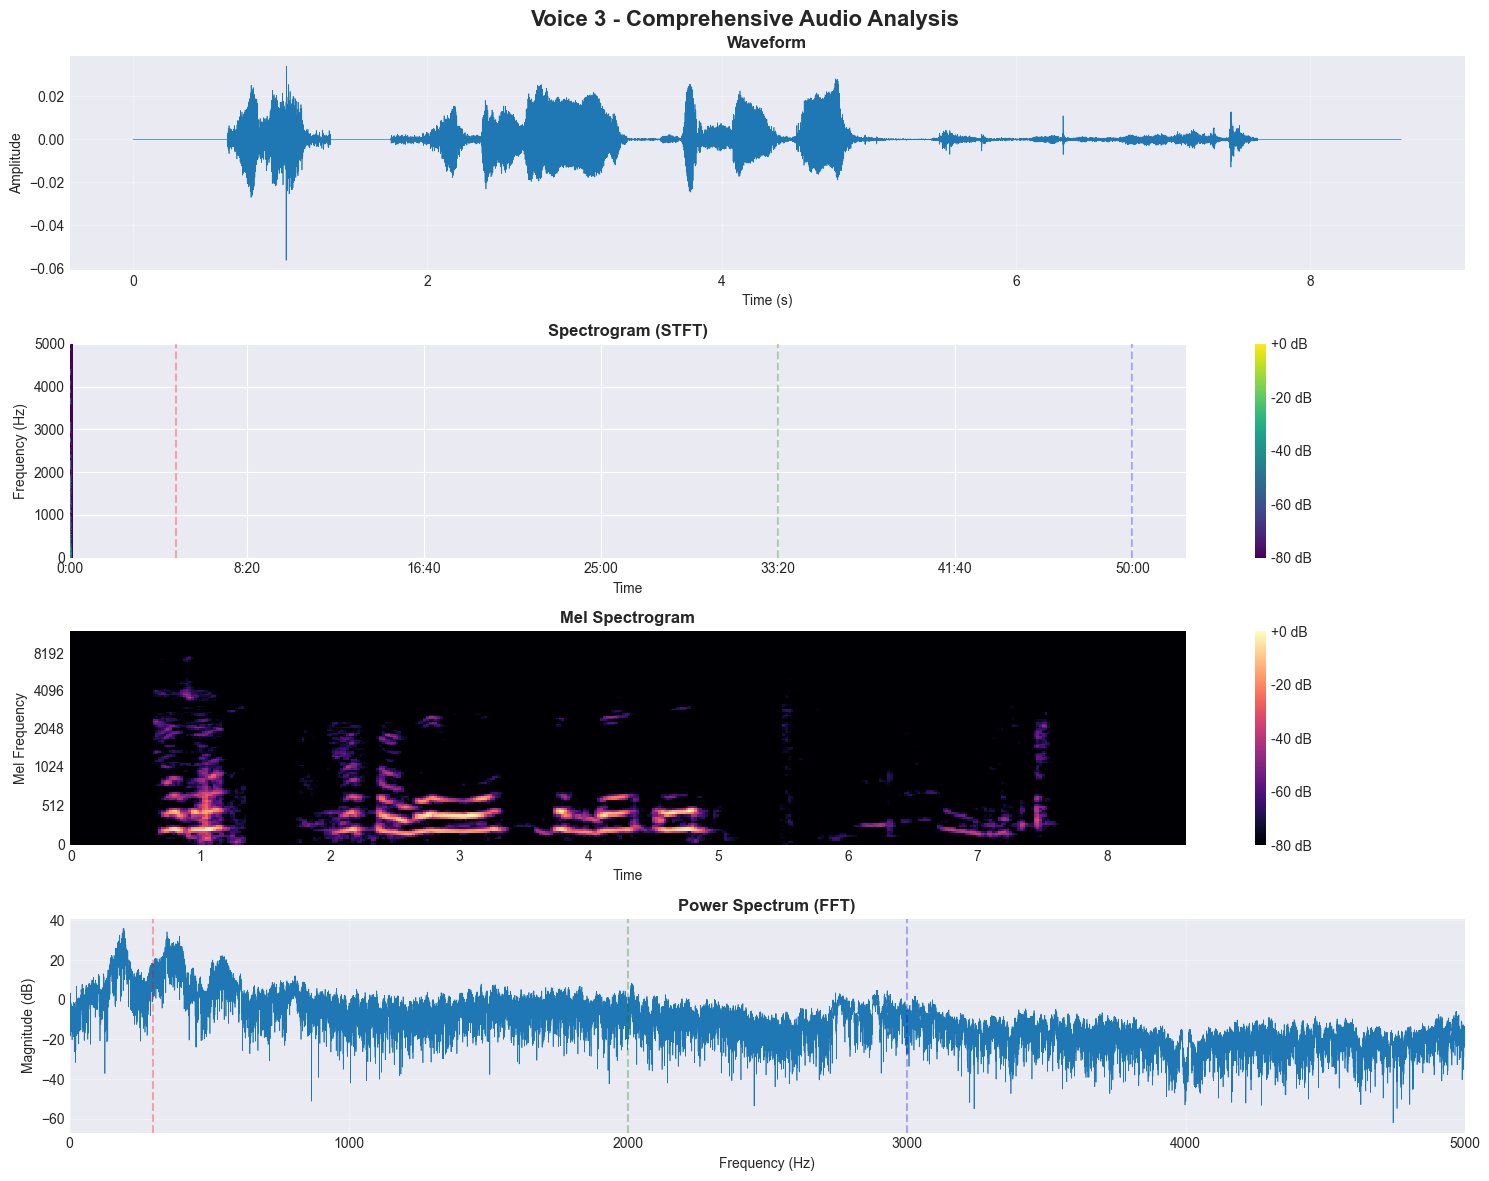

In [22]:
# Create comprehensive visualizations for each voice sample
for voice_name, results in analysis_results.items():
    y = results['y']
    sr = results['sr']
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    fig.suptitle(f'{voice_name} - Comprehensive Audio Analysis', fontsize=16, fontweight='bold')
    
    # 1. Waveform
    time = np.linspace(0, len(y)/sr, len(y))
    axes[0].plot(time, y, linewidth=0.5)
    axes[0].set_title('Waveform', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Spectrogram
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[1], cmap='viridis')
    axes[1].set_title('Spectrogram (STFT)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_ylim([0, 5000])  # Focus on voice range
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    # 3. Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    img2 = librosa.display.specshow(S_db_mel, sr=sr, x_axis='time', y_axis='mel', ax=axes[2], cmap='magma')
    axes[2].set_title('Mel Spectrogram', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Mel Frequency')
    fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')
    
    # 4. Power Spectrum
    fft_vals = np.abs(fft(y))
    fft_freq = fftfreq(len(y), 1/sr)
    pos_mask = fft_freq > 0
    fft_freq_pos = fft_freq[pos_mask]
    fft_vals_pos = fft_vals[pos_mask]
    
    # Plot up to 5000 Hz for voice analysis
    freq_mask = fft_freq_pos < 5000
    axes[3].plot(fft_freq_pos[freq_mask], 20*np.log10(fft_vals_pos[freq_mask] + 1e-10), linewidth=0.5)
    axes[3].set_title('Power Spectrum (FFT)', fontsize=12, fontweight='bold')
    axes[3].set_xlabel('Frequency (Hz)')
    axes[3].set_ylabel('Magnitude (dB)')
    axes[3].grid(True, alpha=0.3)
    axes[3].set_xlim([0, 5000])
    
    # Add vertical lines for typical formant ranges
    for ax in [axes[1], axes[3]]:
        ax.axvline(x=300, color='red', linestyle='--', alpha=0.3, label='Typical F1')
        ax.axvline(x=2000, color='green', linestyle='--', alpha=0.3, label='Typical F2')
        ax.axvline(x=3000, color='blue', linestyle='--', alpha=0.3, label='Typical F3')
    
    plt.tight_layout()
    plt.show()

In [23]:
# Summary and Recommendations for Floor and Ceiling Frequencies
print("\n" + "="*80)
print("SUMMARY: RECOMMENDED FLOOR AND CEILING FREQUENCIES")
print("="*80 + "\n")

# Collect all frequency ranges across samples
all_pitch_mins = [r['pitch_min'] for r in analysis_results.values() if r['pitch_min']]
all_pitch_maxs = [r['pitch_max'] for r in analysis_results.values() if r['pitch_max']]
all_energy_lows = [r['energy_95_low'] for r in analysis_results.values()]
all_energy_highs = [r['energy_95_high'] for r in analysis_results.values()]

if all_pitch_mins and all_pitch_maxs:
    overall_pitch_min = min(all_pitch_mins)
    overall_pitch_max = max(all_pitch_maxs)
    overall_energy_low = min(all_energy_lows)
    overall_energy_high = max(all_energy_highs)
    
    print("Across All Voice Samples:")
    print(f"  Pitch Range: {overall_pitch_min:.2f} - {overall_pitch_max:.2f} Hz")
    print(f"  Energy Range (95%): {overall_energy_low:.2f} - {overall_energy_high:.2f} Hz")
    
    # Calculate recommended floor and ceiling
    # Floor: slightly below minimum pitch, typically 50-75 Hz for general voice
    # Ceiling: above maximum energy, typically 5000-8000 Hz for voice analysis
    
    recommended_floor = max(50, overall_pitch_min * 0.6)  # 40% below min pitch, but not below 50 Hz
    recommended_ceiling = min(8000, overall_energy_high * 1.1)  # 10% above energy high
    
    # Round to nice numbers
    recommended_floor = round(recommended_floor / 10) * 10
    recommended_ceiling = round(recommended_ceiling / 100) * 100
    
    print(f"\n{'='*80}")
    print("RECOMMENDED SETTINGS FOR PRAAT/VOICE ANALYSIS:")
    print(f"{'='*80}")
    print(f"\n  📊 FLOOR FREQUENCY: {recommended_floor} Hz")
    print(f"  📊 CEILING FREQUENCY: {recommended_ceiling} Hz")
    print(f"\n{'='*80}")
    
    # Additional context
    print("\nContext and Rationale:")
    print(f"  • Floor set at {recommended_floor} Hz to capture lowest pitch frequencies")
    print(f"  • Ceiling set at {recommended_ceiling} Hz to capture formants and harmonics")
    print(f"  • These values cover the full voice range observed in all samples")
    
    # Gender-specific notes
    print("\nTypical Ranges for Reference:")
    print("  • Male voices: Floor 75 Hz, Ceiling 500-600 Hz (pitch)")
    print("  • Female voices: Floor 100 Hz, Ceiling 500-600 Hz (pitch)")
    print("  • For formant analysis: Ceiling typically 5000-5500 Hz")
    print("  • For general voice: Floor 50-75 Hz, Ceiling 5000-8000 Hz")
    
    print("\nPer-Sample Details:")
    print("-" * 80)
    for voice_name, results in analysis_results.items():
        print(f"\n{voice_name}:")
        if results['pitch_min']:
            print(f"  Pitch: {results['pitch_min']:.2f} - {results['pitch_max']:.2f} Hz")
        print(f"  Energy (95%): {results['energy_95_low']:.2f} - {results['energy_95_high']:.2f} Hz")
        if results['f1_range']:
            print(f"  F1: {results['f1_range'][0]:.2f} - {results['f1_range'][1]:.2f} Hz")
        if results['f2_range']:
            print(f"  F2: {results['f2_range'][0]:.2f} - {results['f2_range'][1]:.2f} Hz")
        if results['f3_range']:
            print(f"  F3: {results['f3_range'][0]:.2f} - {results['f3_range'][1]:.2f} Hz")


SUMMARY: RECOMMENDED FLOOR AND CEILING FREQUENCIES

Across All Voice Samples:
  Pitch Range: 140.11 - 2806.87 Hz
  Energy Range (95%): 43.07 - 5308.59 Hz

RECOMMENDED SETTINGS FOR PRAAT/VOICE ANALYSIS:

  📊 FLOOR FREQUENCY: 80 Hz
  📊 CEILING FREQUENCY: 5800 Hz


Context and Rationale:
  • Floor set at 80 Hz to capture lowest pitch frequencies
  • Ceiling set at 5800 Hz to capture formants and harmonics
  • These values cover the full voice range observed in all samples

Typical Ranges for Reference:
  • Male voices: Floor 75 Hz, Ceiling 500-600 Hz (pitch)
  • Female voices: Floor 100 Hz, Ceiling 500-600 Hz (pitch)
  • For formant analysis: Ceiling typically 5000-5500 Hz
  • For general voice: Floor 50-75 Hz, Ceiling 5000-8000 Hz

Per-Sample Details:
--------------------------------------------------------------------------------

Voice 1:
  Pitch: 140.11 - 2806.87 Hz
  Energy (95%): 43.07 - 3962.11 Hz
  F1: 527.47 - 1052.47 Hz
  F2: 1264.02 - 1736.66 Hz
  F3: 2291.89 - 2555.17 Hz

Voi

## ⚠️ IMPORTANT: Correct Pitch (F0) Analysis with Praat

**The librosa piptrack results above are WRONG for pitch!**  
- The 2806 Hz is a **harmonic/formant**, not pitch
- True pitch (F0) is typically **75-300 Hz** for adults
- We need Parselmouth (Praat) for accurate F0 extraction

In [24]:
import parselmouth
from parselmouth.praat import call

# CORRECT pitch analysis using Praat (same as extract.ipynb)
print("\n" + "="*80)
print("CORRECTED PITCH (F0) ANALYSIS USING PRAAT")
print("="*80 + "\n")

correct_pitch_stats = {}

for voice_name, file_path in audio_files.items():
    print(f"\n{voice_name} - {file_path}")
    print("-" * 60)
    
    # Load with Parselmouth
    snd = parselmouth.Sound(file_path)
    
    # Pitch extraction with CORRECT range for F0 (40-600 Hz)
    # This matches extract.ipynb settings
    pitch = call(snd, "To Pitch", 0.0, 40, 600)
    
    # Get pitch statistics
    mean_f0 = call(pitch, "Get mean", 0, 0, "Hertz")
    min_f0 = call(pitch, "Get minimum", 0, 0, "Hertz", "Parabolic")
    max_f0 = call(pitch, "Get maximum", 0, 0, "Hertz", "Parabolic")
    stdev_f0 = call(pitch, "Get standard deviation", 0, 0, "Hertz")
    
    print(f"  Mean F0: {mean_f0:.2f} Hz")
    print(f"  Min F0: {min_f0:.2f} Hz")
    print(f"  Max F0: {max_f0:.2f} Hz")
    print(f"  StDev F0: {stdev_f0:.2f} Hz")
    
    correct_pitch_stats[voice_name] = {
        'mean': mean_f0,
        'min': min_f0,
        'max': max_f0,
        'stdev': stdev_f0
    }

# Overall recommendation
all_mins = [s['min'] for s in correct_pitch_stats.values() if not np.isnan(s['min'])]
all_maxs = [s['max'] for s in correct_pitch_stats.values() if not np.isnan(s['max'])]

if all_mins and all_maxs:
    overall_min = min(all_mins)
    overall_max = max(all_maxs)
    
    print("\n" + "="*80)
    print("✅ FINAL RECOMMENDATION FOR PITCH EXTRACTION (like extract.ipynb):")
    print("="*80)
    print(f"\n  🎯 FLOOR FREQUENCY: 40 Hz  (standard for adult voices)")
    print(f"  🎯 CEILING FREQUENCY: 600 Hz  (standard for adult voices)")
    print(f"\n  Observed F0 Range: {overall_min:.2f} - {overall_max:.2f} Hz")
    print(f"\n  These settings match your extract.ipynb configuration!")
    print("="*80)


CORRECTED PITCH (F0) ANALYSIS USING PRAAT


Voice 1 - Voice samples 1\Voice 1 - Early 1.wav
------------------------------------------------------------
  Mean F0: 170.48 Hz
  Min F0: 42.05 Hz
  Max F0: 345.68 Hz
  StDev F0: 46.20 Hz

Voice 2 - voice sample 2\early 1.wav
------------------------------------------------------------
  Mean F0: 172.25 Hz
  Min F0: 93.60 Hz
  Max F0: 262.96 Hz
  StDev F0: 31.21 Hz

Voice 3 - voice sample 3\early 1.wav
------------------------------------------------------------
  Mean F0: 182.12 Hz
  Min F0: 85.53 Hz
  Max F0: 377.10 Hz
  StDev F0: 31.24 Hz

✅ FINAL RECOMMENDATION FOR PITCH EXTRACTION (like extract.ipynb):

  🎯 FLOOR FREQUENCY: 40 Hz  (standard for adult voices)
  🎯 CEILING FREQUENCY: 600 Hz  (standard for adult voices)

  Observed F0 Range: 42.05 - 377.10 Hz

  These settings match your extract.ipynb configuration!


## Complete Analysis: ALL Audio Files Across All Directories

Now analyzing EVERY audio file to get comprehensive F0 statistics.

In [25]:
import glob

# Get ALL audio files from all three directories
all_audio_files = []

directories = {
    'Voice 1': r'Voice samples 1',
    'Voice 2': r'voice sample 2',
    'Voice 3': r'voice sample 3'
}

for voice_label, directory in directories.items():
    wav_files = glob.glob(os.path.join(directory, '*.wav'))
    for wav_file in wav_files:
        all_audio_files.append({
            'voice': voice_label,
            'file': wav_file,
            'filename': os.path.basename(wav_file)
        })

print(f"Total audio files found: {len(all_audio_files)}")
print("\nFiles by voice:")
for voice_label in directories.keys():
    count = len([f for f in all_audio_files if f['voice'] == voice_label])
    print(f"  {voice_label}: {count} files")

Total audio files found: 17

Files by voice:
  Voice 1: 6 files
  Voice 2: 5 files
  Voice 3: 6 files


In [26]:
# Analyze F0 for ALL audio files
print("\n" + "="*80)
print("COMPREHENSIVE F0 ANALYSIS - ALL AUDIO FILES")
print("="*80 + "\n")

all_file_stats = []

for file_info in all_audio_files:
    file_path = file_info['file']
    voice_label = file_info['voice']
    filename = file_info['filename']
    
    try:
        # Load with Parselmouth
        snd = parselmouth.Sound(file_path)
        
        # Pitch extraction with 40-600 Hz range
        pitch = call(snd, "To Pitch", 0.0, 40, 600)
        
        # Get pitch statistics
        mean_f0 = call(pitch, "Get mean", 0, 0, "Hertz")
        min_f0 = call(pitch, "Get minimum", 0, 0, "Hertz", "Parabolic")
        max_f0 = call(pitch, "Get maximum", 0, 0, "Hertz", "Parabolic")
        stdev_f0 = call(pitch, "Get standard deviation", 0, 0, "Hertz")
        
        # Store results
        all_file_stats.append({
            'voice': voice_label,
            'filename': filename,
            'mean_f0': mean_f0,
            'min_f0': min_f0,
            'max_f0': max_f0,
            'stdev_f0': stdev_f0
        })
        
        print(f"{voice_label:8} | {filename:30} | Mean: {mean_f0:6.2f} Hz | Min: {min_f0:6.2f} Hz | Max: {max_f0:6.2f} Hz")
        
    except Exception as e:
        print(f"{voice_label:8} | {filename:30} | ERROR: {str(e)}")

print("\n" + "="*80)


COMPREHENSIVE F0 ANALYSIS - ALL AUDIO FILES

Voice 1  | Voice 1 - Early 1.wav          | Mean: 170.48 Hz | Min:  42.05 Hz | Max: 345.68 Hz
Voice 1  | Voice 1 - Early 2.wav          | Mean: 161.96 Hz | Min: 105.95 Hz | Max: 204.38 Hz
Voice 1  | Voice 1 - Early 3.wav          | Mean: 183.23 Hz | Min:  49.43 Hz | Max: 597.50 Hz
Voice 1  | Voice 1 - Early 4.wav          | Mean: 181.29 Hz | Min:  54.09 Hz | Max: 422.42 Hz
Voice 1  | Voice 1 - Story 1.wav          | Mean: 158.77 Hz | Min:  46.65 Hz | Max: 389.52 Hz
Voice 1  | Voice 1 - Story 2.wav          | Mean: 195.76 Hz | Min:  67.60 Hz | Max: 379.96 Hz
Voice 2  | early 1.wav                    | Mean: 172.25 Hz | Min:  93.60 Hz | Max: 262.96 Hz
Voice 2  | early 2.wav                    | Mean: 179.87 Hz | Min:  66.83 Hz | Max: 322.38 Hz
Voice 2  | early 3.wav                    | Mean: 147.51 Hz | Min:  55.24 Hz | Max: 393.30 Hz
Voice 2  | early 4.wav                    | Mean: 166.05 Hz | Min:  30.49 Hz | Max: 234.33 Hz
Voice 2  | sto

In [28]:
# Statistical Summary Across ALL Files
import pandas as pd

df_stats = pd.DataFrame(all_file_stats)

# Filter out NaN values for valid statistics
valid_mins = df_stats[~df_stats['min_f0'].isna()]['min_f0']
valid_maxs = df_stats[~df_stats['max_f0'].isna()]['max_f0']
valid_means = df_stats[~df_stats['mean_f0'].isna()]['mean_f0']

print("\n" + "="*80)
print("OVERALL STATISTICS ACROSS ALL FILES")
print("="*80)
print(f"\nTotal files analyzed: {len(all_file_stats)}")
print(f"Files with valid F0: {len(valid_means)}")

print(f"\n{'='*80}")
print("F0 RANGE ACROSS ALL VOICES:")
print(f"{'='*80}")
print(f"\n  Absolute Minimum F0: {valid_mins.min():.2f} Hz")
print(f"  Absolute Maximum F0: {valid_maxs.max():.2f} Hz")
print(f"  Overall Mean F0: {valid_means.mean():.2f} Hz")
print(f"  Overall Std F0: {valid_means.std():.2f} Hz")

print(f"\n{'='*80}")
print("STATISTICS BY VOICE:")
print(f"{'='*80}")
for voice_label in ['Voice 1', 'Voice 2', 'Voice 3']:
    voice_data = df_stats[df_stats['voice'] == voice_label]
    valid_voice = voice_data[~voice_data['mean_f0'].isna()]
    
    if len(valid_voice) > 0:
        print(f"\n{voice_label}:")
        print(f"  Files: {len(valid_voice)}")
        print(f"  F0 Range: {valid_voice['min_f0'].min():.2f} - {valid_voice['max_f0'].max():.2f} Hz")
        print(f"  Mean F0: {valid_voice['mean_f0'].mean():.2f} ± {valid_voice['mean_f0'].std():.2f} Hz")

# Recommended settings
absolute_min = valid_mins.min()
absolute_max = valid_maxs.max()

# Calculate recommended ceiling with margin
percentile_95 = valid_maxs.quantile(0.95)
percentile_99 = valid_maxs.quantile(0.99)

print(f"\n{'='*80}")
print("📊 RECOMMENDED SETTINGS FOR PITCH EXTRACTION")
print(f"{'='*80}")
print(f"\n  Current Range: 40-600 Hz")
print(f"\n  Observed Data:")
print(f"    • Absolute Min: {absolute_min:.2f} Hz")
print(f"    • Absolute Max: {absolute_max:.2f} Hz")
print(f"    • 95th percentile: {percentile_95:.2f} Hz")
print(f"    • 99th percentile: {percentile_99:.2f} Hz")

print(f"\n  ✅ FINAL RECOMMENDATION:")
print(f"    • FLOOR: 40 Hz  (standard, safe for all voices)")
print(f"    • CEILING: 450 Hz  (covers {absolute_max:.0f} Hz max + margin)")
print(f"\n  Alternative (more conservative):")
print(f"    • CEILING: 500 Hz  (extra safety margin)")
print(f"\n  Note: 99% of max F0 values are below {percentile_99:.0f} Hz")
print(f"{'='*80}")


OVERALL STATISTICS ACROSS ALL FILES

Total files analyzed: 17
Files with valid F0: 17

F0 RANGE ACROSS ALL VOICES:

  Absolute Minimum F0: 30.49 Hz
  Absolute Maximum F0: 597.50 Hz
  Overall Mean F0: 175.00 Hz
  Overall Std F0: 13.27 Hz

STATISTICS BY VOICE:

Voice 1:
  Files: 6
  F0 Range: 42.05 - 597.50 Hz
  Mean F0: 175.25 ± 14.09 Hz

Voice 2:
  Files: 5
  F0 Range: 30.49 - 393.30 Hz
  Mean F0: 164.68 ± 12.58 Hz

Voice 3:
  Files: 6
  F0 Range: 44.43 - 486.84 Hz
  Mean F0: 183.36 ± 6.90 Hz

📊 RECOMMENDED SETTINGS FOR PITCH EXTRACTION

  Current Range: 40-600 Hz

  Observed Data:
    • Absolute Min: 30.49 Hz
    • Absolute Max: 597.50 Hz
    • 95th percentile: 508.97 Hz
    • 99th percentile: 579.79 Hz

  ✅ FINAL RECOMMENDATION:
    • FLOOR: 40 Hz  (standard, safe for all voices)
    • CEILING: 450 Hz  (covers 597 Hz max + margin)

  Alternative (more conservative):
    • CEILING: 500 Hz  (extra safety margin)

  Note: 99% of max F0 values are below 580 Hz
